In [ ]:
#spotify-audio-metrics: 
#acoustic(ness)
#A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.	Float

#dance(ability)
#Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat #strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.	Float

#duration_ms
#The duration of the track in milliseconds.	Integer

#energy
#Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, #loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to #this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.	Float

#instrumental(ness)
#Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks #are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values #above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.	Float

#key (0..11)
#The key the track is in. Integers map to pitches using standard Pitch Class notation . E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on.	Integer

#live(ness)
#Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed #live. A value above 0.8 provides strong likelihood that the track is live.	Float

#loud(ness)
#The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative #loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values #typically range between -60 and 0 db.	Float

#mode
#Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by #1 and minor is 0.	Integer

#speech(iness)
#Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the 
#recording (e.g. talk show, audio book, #poetry), the closer to 1.0 the attribute value. 
#Values above 0.66 describe tracks that are probably made entirely of spoken words. 
#Values #between 0.33 and 0.66 describe tracks that may contain both music and speech, 
#either in sections or layered, including such cases as rap #music. Values below 0.33 most likely 
#represent music and other non-speech-like tracks.	Float

#tempo
#The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and #derives directly from the average beat duration.	Float

#time_signature
#An estimated overall time signature of a track. The time signature (meter) is a notational convention to specify how many beats are in each #bar (or measure).	Integer

#valence
#A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, #cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

-> https://drive.google.com/drive/folders/15MeuNRZvUy24oKmBqTa699o-6K2Ld6fE

In [19]:
#used libraries
import pandas as pd
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer, MaxAbsScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [1]:
import pandas as pd

# read 5000-csv data
data = pd.read_csv("../Data/df_audio_features_5000.csv")

# drop duplicates (artist+songname)
data_cleaned=data.copy()
data_cleaned.drop_duplicates(subset=['artist','name'],inplace=True)

# remove (uninteresting) columns
data_cleaned.drop(['duration_ms',    #less expressiveness in context of "playlist" ("leicop")
                   'key',            #less expressiveness?
                   'time_signature', #leicop
                   'html',           #spotify-link (uninteresting...for now)
                   'type'            #empty!
                  ], inplace=True, axis=1)

# rename longnamed columns (for "nicer" diagram-legends)
data_cleaned.rename(columns={"acousticness":"acoustic", 
                             "instrumentalness":"instrument",
                             "danceability":"dance",
                             "speechiness":"speech",
                             "loudness":"loud",
                             "liveness":"live"
                            },inplace=True)

#reindex: id/name/artist
data_cleaned.set_index(["id","name","artist"],inplace=True)

#save (first version) cleaned dataset (columns)
data_cleaned.to_csv("../Data/df_audio_features_5000_cleaned.csv")


In [2]:
import sys, os
sys.path.append(os.path.join(os.path.dirname('.'), '..'))
from src.proj4_utils import test_num_data_scale
from sys import maxsize as sys_maxsize
scale_dict = {'key' : (-1, 11), 
              'loud' : (-60, 0), 
              'time_signature' : (3, 7), 
              'duration_ms' : (0, sys_maxsize), 
              'tempo' : (0, sys_maxsize),
              'default' : (0, 1)}

test_num_data_scale(data_cleaned, scale_dict)

Columns ['key', 'time_signature', 'duration_ms'] not found in passed df_num.


RuntimeError: test_num_data_scale: columns ['loud'] have forbidden max values

In [5]:
#check scaling
#scale data with several scalers/transformers & plot & save it 

# check & visualize scaling
def checkScaler(data,scaler,plotit=False,plotsubtitle=""):
  data_trans = scaler.fit_transform(data)
  
  # ...back to dataframe
  data_scaled=pd.DataFrame(data_trans,columns=data.columns,index=data.index)

  # plot & save it
  if plotit:
    plt.subplots(figsize=(16, 5))
    sns.boxplot(data=data_scaled)
    #generate title
    scalertype=str(scaler.__class__)
    title=scalertype[scalertype.rindex(".")+1:].replace("'>","")+plotsubtitle

    plt.title(title)
    plt.savefig("../Plot/"+title)
    plt.show()
  return data_scaled
    
#try different (potential) scaler  
for scaler in [StandardScaler(),     # Standardize features by removing the mean and scaling to unit variance.
               MinMaxScaler(),       # Transform features by scaling each feature to a given range.
               RobustScaler(),       # Scale features using statistics that are robust to outliers.
               MaxAbsScaler()        # Scale each feature by its maximum absolute value.
              ]:
    
    checkScaler(data_cleaned,scaler,plotit=True,plotsubtitle="@cleaned data")
    
#  df_af_pre = scaler.fit_transform(df_af)
#  # ...and back to dataframe
#  df_af_scaled=pd.DataFrame(df_af_pre, columns=df_af.columns, index=df_af.index)
#  # plot & save it
#  plt.subplots(figsize=(8, 5))
#  sns.boxplot(data=df_af_scaled)
#  #generate title
#  scalertype=str(scaler.__class__)
#  title=scalertype[scalertype.rindex(".")+1:].replace("'>","")+"@raw data"

#  plt.title(title)
#  plt.savefig("../Plot/"+title)
#  plt.show()

# calculate & plot Euclidean distance
#ecl_dis=pd.DataFrame(pairwise_distances(df_af), index=df_af.index, columns=df_af.index)
#ecl_dis
#plt.subplots(figsize=(12, 8))
#sns.heatmap(ecl_dis)
#plt.show()

# calculate & plot Manhattan distance
#ecl_man=pd.DataFrame(pairwise_distances(df_af, metric='manhattan'), index=df_af.index, columns=df_af.index)
#ecl_man
#plt.subplots(figsize=(12, 8))
#sns.heatmap(ecl_man)
#plt.show()

#==> agreement group-session 23.6.:
#1) RobustScaling with loud(ness),speech(iness),live(ness) and tempo
data_scaled=data_cleaned.copy()
for col in ("loud","speech","live","tempo"):
  data_scaled[[col]]=checkScaler(data_scaled[[col]],RobustScaler())

#2) StandardScaling with ALL columns
data_scaled=checkScaler(data_scaled,StandardScaler(),plotit=True,plotsubtitle="@prescaled cleaned data(final)")


NameError: name 'StandardScaler' is not defined

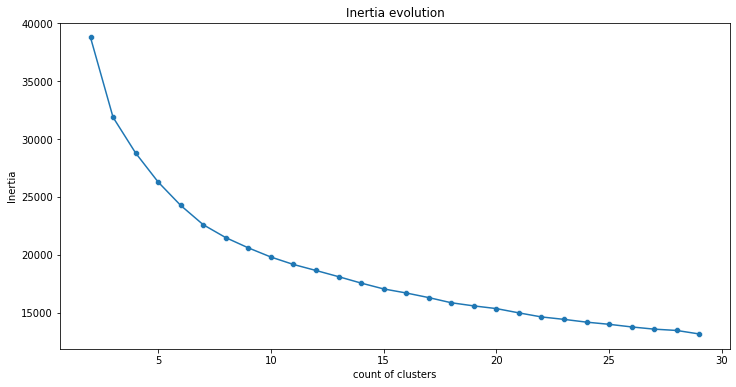

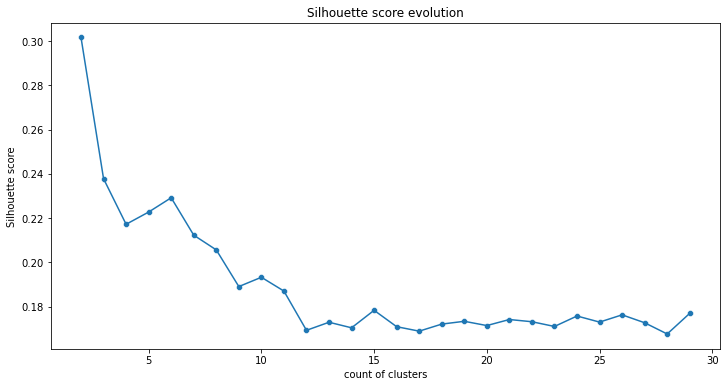

In [63]:
#find optimal number of clusters
#https://www.codecademy.com/learn/machine-learning/modules/dspath-clustering/cheatsheet :
#To find the optimal K for a dataset, use the Elbow method; find the point where the decrease in inertia begins to slow. 

def checkClustering(data, maxclusters=30):
    inertia = []
    silhouette_score_list = []

    for k in range(2, maxclusters):
        k_means = KMeans(n_clusters=k, random_state=123)
        k_means.fit(data)

        inertia.append(k_means.inertia_)
        silhouette_score_list.append(silhouette_score(data, k_means.labels_))

    # Plot inertia
    fig, ax = plt.subplots(figsize=(12, 6))
    plt.title(f'Inertia evolution')
    sns.lineplot(x=range(2, maxclusters), y=inertia)
    sns.scatterplot(x=range(2, maxclusters), y=inertia)
    plt.xlabel('count of clusters')
    plt.ylabel('Inertia')
    plt.savefig('../Plot/Inertia')
    plt.show()

    # Plot silhouette score
    fig, ax = plt.subplots(figsize=(12, 6))
    plt.title(f'Silhouette score evolution')
    sns.lineplot(x=range(2, maxclusters), y=silhouette_score_list)
    sns.scatterplot(x=range(2, maxclusters), y=silhouette_score_list)
    plt.xlabel('count of clusters')
    plt.ylabel('Silhouette score')
    plt.savefig('../Plot/Silhouette_score')
    plt.show()
    
checkClustering(data_scaled, maxclusters=30)  

# ==> a good number of clusters is between 10 and 15

In [29]:
# match with myjam data
import pandas as pd
# read jam-main-file (spotify_uri=spotify:track:2ZM9sVP0blBj1lNIEg4dgn)
df_mj = pd.read_csv("../Data/myjam/jams.tsv",sep='\t',error_bad_lines=False)
#map spotify-id -> jam-id
map=dict(zip(df_mj.spotify_uri.str.replace("spotify:track:",""),df_mj.jam_id))

#print(map)
#for i in range(10):
#  print(str(list(map.keys())[i]) + "," + str(list(map.values())[i]))
 # print(3)

# read 5000-csv data (id=spotify-id)
df_af = pd.read_csv("../Data/df_audio_features_5000.csv")
# set index=spotify-id
#df_af.set_index(["id"],inplace=True)

#for spid in list(df_af["id"]):
#for i in range(len(df_af)):
#  print(df_af.loc[i]["id"])

#df_af["jam_id"]=map[str(df_af[["id"]])]

#df_af

for i, row in df_af.iterrows():
  #print(row['id'])
  #row["jam_id"]="xxx"
  id=row["id"]
  print(id)
  if id in map.keys():
    df_af.at[i,'jam_id'] = map[id]
    
df_af    

#for column in df_af[['id']]:
#   columnSeriesObj = df_af[column]
#   print('Colunm Name : ', column)
#   print('Column Contents : ', df_af.values)





F:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3444: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
b'Skipping line 847128: expected 7 fields, saw 8\n'
b'Skipping line 1091152: expected 7 fields, saw 8\nSkipping line 1175374: expected 7 fields, saw 8\n'
b'Skipping line 1225934: expected 7 fields, saw 8\nSkipping line 1255356: expected 7 fields, saw 8\nSkipping line 1279670: expected 7 fields, saw 8\n'
b'Skipping line 1330674: expected 7 fields, saw 8\n'
b'Skipping line 1448032: expected 7 fields, saw 8\nSkipping line 1543892: expected 7 fields, saw 8\n'
b'Skipping line 1579568: expected 7 fields, saw 8\nSkipping line 1612447: expected 7 fields, saw 8\n'
b'Skipping line 1784587: expected 7 fields, saw 8\n'


1n7JnwviZ7zf0LR1tcGFq7 
5QGM1U0eCYrQuwSJwTm5Zq 
0NLIFSZxPzQhCwnkn5PJYs 
3mXqOdlLE1k67WsAxryPFs 
7bSzjzjTkWT2CkIPPdp0eA 
5pstSsK0G4q86gdyy1Spqh 
33u3dO0JWjerYpFN61J3ug 
0ylJQpV3K4XnhWhLDMFmH7 
1wL2dk42Cxu4zCJs4SvFsZ 
5iKuMCDh634YGrg2HrhtHp 
4xGFcQEIjtmbPD6Jsxq14M 
26g2HsIOznFYeJWR9zhRXZ 
1OzHkIzGMj4S3rWwF8TBjc 
3gDzuF3Dy0K4RQszBFAYCv 
51P5Djwsur61UY4oitktOQ 
2RPHy1PlxehscIM1K1wQMy 
52mwxbVQOtYXntgvyXyBc4 
60FNhq77JIoQsUKwf0wf5m 
3ftxaxht5yQW99vNcibmUC 
5gvBgfXusUpxjOWHyYJXVg 
4P9HLmNcE6dUUvsPUvl3gs 
3pjbCjL1IlqOfuQ8YOkX6o 
65GsUbgQju5Mh0Ab7CRUWB 
014sDbzN0MSugmC703Ic4h 
2rIzPAaLY6ocCanj5H7edQ 
37H0kOistSqxRH8rObQeIe 
7BlLxHwobm2gHjXev9dNVe 
4WfT503LMc9zLewdsok9un 
1wo6p8AMWXREZVowQCa4BC 
1htDFdG7K6pW07cuIanjGG 
09VxH0oobfXR1bRXZ78VXP 
7bM4h5zu7FkChGbSeozZVN 
596scNUBRpj2AygfaBVyTj 
4PwzeZs0cTVuzZbCmw85hc 
22QBm5IGpx49Ggg7b0DMhL 
4Lx7fiZRVb7j4U1xFZ9fyo 
2BkIiZYOniMrWBBlADyVNX 
4lnLWhIiUKxq4Rh898vkVk 
1b0Mc4h1XFArQAnQYBmIQb 
5Q2pilVN5fcIfzWGF9aGvV 
1SEK1Yd01136xaLxAe0G70 
7fnFmtEpfKLnJRka

,name,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,duration_ms,time_signature,id,html
0,Se Eu Quiser Falar Com Deus ...,Gilberto Gil,0.6580,0.25900,11,-13.141,0,0.0705,0.694,0.000059,0.9750,0.3060,110.376,,256213,4,1n7JnwviZ7zf0LR1tcGFq7,https://open.spotify.com/track/1n7JnwviZ7zf0LR...
1,Saudade De Bahia ...,Antônio Carlos Jobim,0.7420,0.39900,2,-12.646,1,0.0346,0.217,0.000002,0.1070,0.6930,125.039,,191867,4,5QGM1U0eCYrQuwSJwTm5Zq,https://open.spotify.com/track/5QGM1U0eCYrQuwS...
2,"Canta Canta, Minha Gente ...",Martinho Da Vila,0.8510,0.73000,2,-11.048,1,0.3470,0.453,0.000063,0.1240,0.9050,93.698,,152267,4,0NLIFSZxPzQhCwnkn5PJYs,https://open.spotify.com/track/0NLIFSZxPzQhCwn...
3,Mulher Eu Sei ...,Chico César,0.7050,0.05020,4,-18.115,1,0.0471,0.879,0.000041,0.3860,0.5240,106.802,,186227,4,3mXqOdlLE1k67WsAxryPFs,https://open.spotify.com/track/3mXqOdlLE1k67Ws...
4,Rosa Morena ...,Kurt Elling,0.6510,0.11900,6,-19.807,1,0.0380,0.916,0.000343,0.1040,0.4020,120.941,,273680,4,7bSzjzjTkWT2CkIPPdp0eA,https://open.spotify.com/track/7bSzjzjTkWT2CkI...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5230,"1812 Festival Overture, Op. 49: 1812 Overture,...",Pyotr Ilyich Tchaikovsky,0.2020,0.06940,3,-23.390,1,0.0473,0.917,0.715000,0.0832,0.0655,87.906,,995000,4,1aEhYlZtypmipA06SDJ4U3,https://open.spotify.com/track/1aEhYlZtypmipA0...
5231,"Winter Fragments pour ensemble instrumental, s...",Tristan Murail,0.1880,0.10100,6,-21.873,1,0.0442,0.855,0.426000,0.0694,0.0355,83.134,,855000,4,1Gfqe7TAKklmuZf6hxsH6h,https://open.spotify.com/track/1Gfqe7TAKklmuZf...
5232,"Schoenberg: 5 Orchestral Pieces, Op. 16: No. 3...",Arnold Schoenberg,0.0596,0.00093,9,-42.959,1,0.0434,0.951,0.969000,0.0772,0.0344,71.573,,238187,3,2XNwnFrdMDpismp0VUZ7cU,https://open.spotify.com/track/2XNwnFrdMDpismp...
5233,"Serenade For Strings In E, Op.22, B. 52: 1. Mo...",Antonín Dvořák,0.1330,0.02080,4,-29.443,1,0.0419,0.883,0.505000,0.1110,0.0591,67.109,,314307,4,7ucDwgMtE3YJtEfTbuRhy0,https://open.spotify.com/track/7ucDwgMtE3YJtEf...
